In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# load local version of gallifrey, before pip installed version, for debugging
import pathlib
import sys
import os

sys.path.append(str(pathlib.Path(os.getcwd()).parent.joinpath("src")))

In [3]:
import yt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from gallifrey.model import Model
from gallifrey.analysis import count_planets
from gallifrey.utilities.math import calculate_pca
from gallifrey.utilities.dataframe import rename_labels
from gallifrey.visualization.visualization_utils import (
    set_plot_defaults,
    get_palette,
    FigureProcessor,
    adjust_legend,
    ridgeplot,
)

## DATA SETUP

In [4]:
snapshot = 127
resolution = 8192
sim_id = "37_11"
num_embryos = 50
host_star_masses = 1
planet_categories = [
    "Earth",
    "Super-Earth",
    "Neptunian",
    "Sub-Giant",
    "Giant",
]

In [5]:
model = Model(
    snapshot=snapshot,
    resolution=resolution,
    sim_id=sim_id,
)
ds = model.ds
mw = model.halo


      DETECTED LOCAL MACHINE: Test snapshot loaded.


      CONFIG: Setting resolution to 4096.


      CONFIG: Setting sim_id to 09_18.

yt : [INFO     ] 2023-10-30 19:16:28,964 Calculating time from 1.000e+00 to be 4.318e+17 seconds
yt : [INFO     ] 2023-10-30 19:16:29,024 Parameters: current_time              = 4.318436660023809e+17 s
yt : [INFO     ] 2023-10-30 19:16:29,025 Parameters: domain_dimensions         = [1 1 1]
yt : [INFO     ] 2023-10-30 19:16:29,025 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-10-30 19:16:29,026 Parameters: domain_right_edge         = [100. 100. 100.]
yt : [INFO     ] 2023-10-30 19:16:29,026 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2023-10-30 19:16:29,026 Parameters: current_redshift          = 4.440892098500626e-16
yt : [INFO     ] 2023-10-30 19:16:29,027 Parameters: omega_lambda              = 0.682
yt : [INFO     ] 2023-10-30 19:16:29,027 Parameters: omega_matter              = 0.318
yt : [INFO     ] 202

## PLOT SETUP

In [6]:
set_plot_defaults()

figure_subdirectory = f"MilkyWayAnalogue/{model.resolution}/{model.sim_id}/{model.snapshot}/Metallicity_model_effects"
save = True

## CREATE DATA SOURCE

In [7]:
radius = 0.2 * mw.virial_radius()

## EFFECTS OF METALLICITY MODEL ON PLANET TYPES

In [8]:
no_metallicity_cut = count_planets(
    model,
    lambda: mw.sphere(radius=radius),
    planet_categories,
    normalize_by="planet_hosting_number",
    model_config={"ngpps_hard_bounds": "none"},
    long_format=True,
    value_name="Occurence Rate",
    description={"Metallicity Model": "Without [Fe/H] Cut"},
)
metallicity_cut = count_planets(
    model,
    lambda: mw.sphere(radius=radius),
    planet_categories,
    normalize_by="planet_hosting_number",
    model_config={"ngpps_hard_bounds": "lower"},
    long_format=True,
    value_name="Occurence Rate",
    description={"Metallicity Model": "With [Fe/H] Cut"},
)
occurrence_rate_combined = pd.concat(
    [no_metallicity_cut, metallicity_cut], ignore_index=True
)


      TIMER: Block 'Adding Planets...' took 1.05 seconds.


      CONFIG: Setting ngpps_hard_bounds to lower.


      TIMER: Block 'Adding Planets...' took 1.05 seconds.



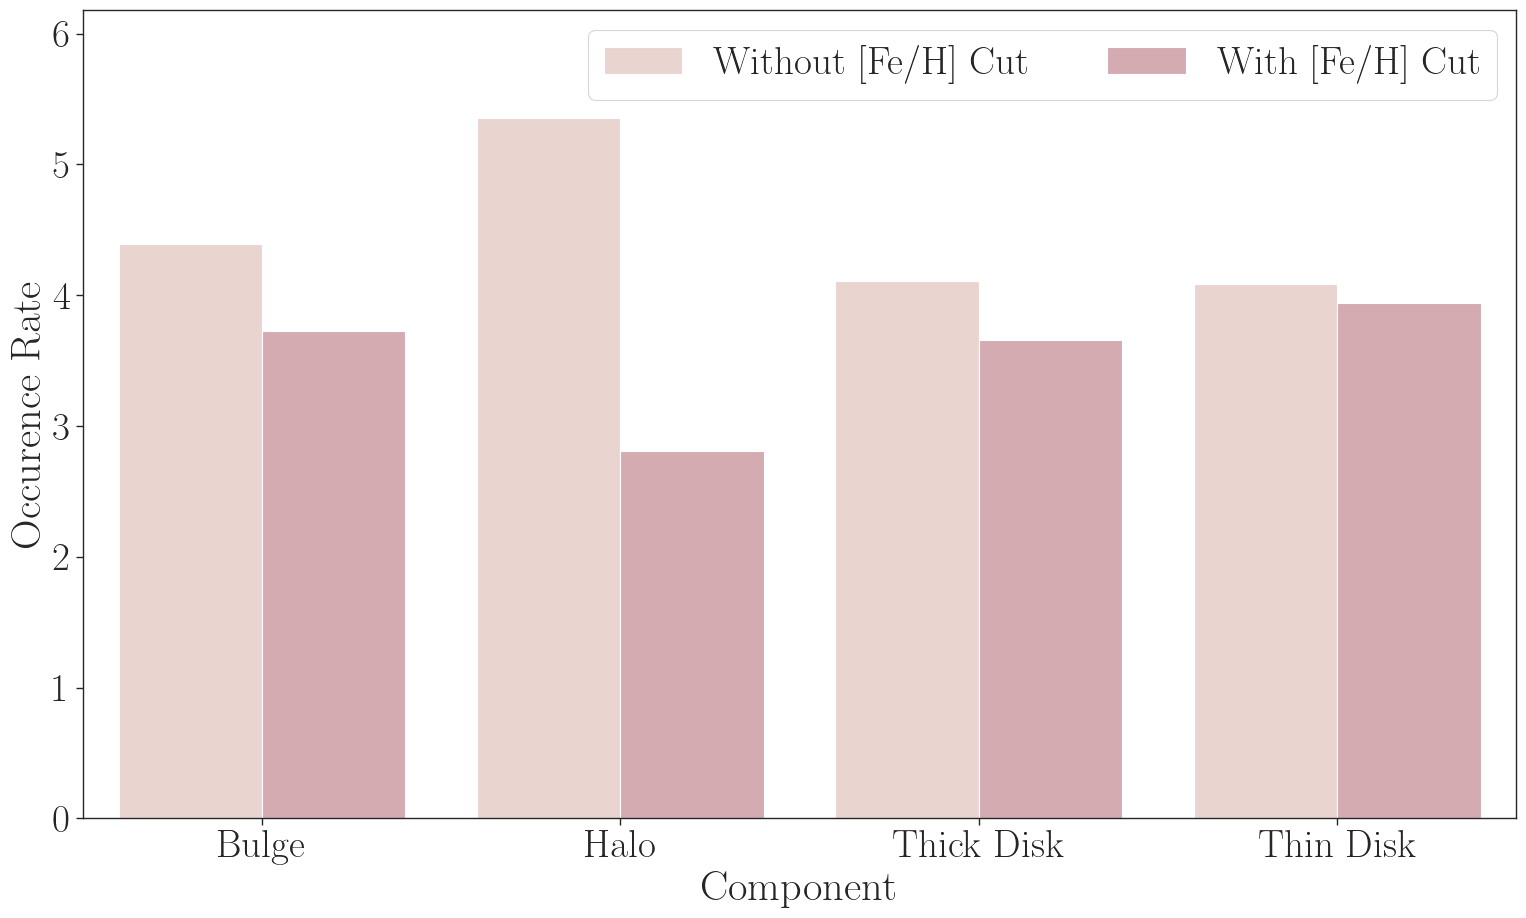

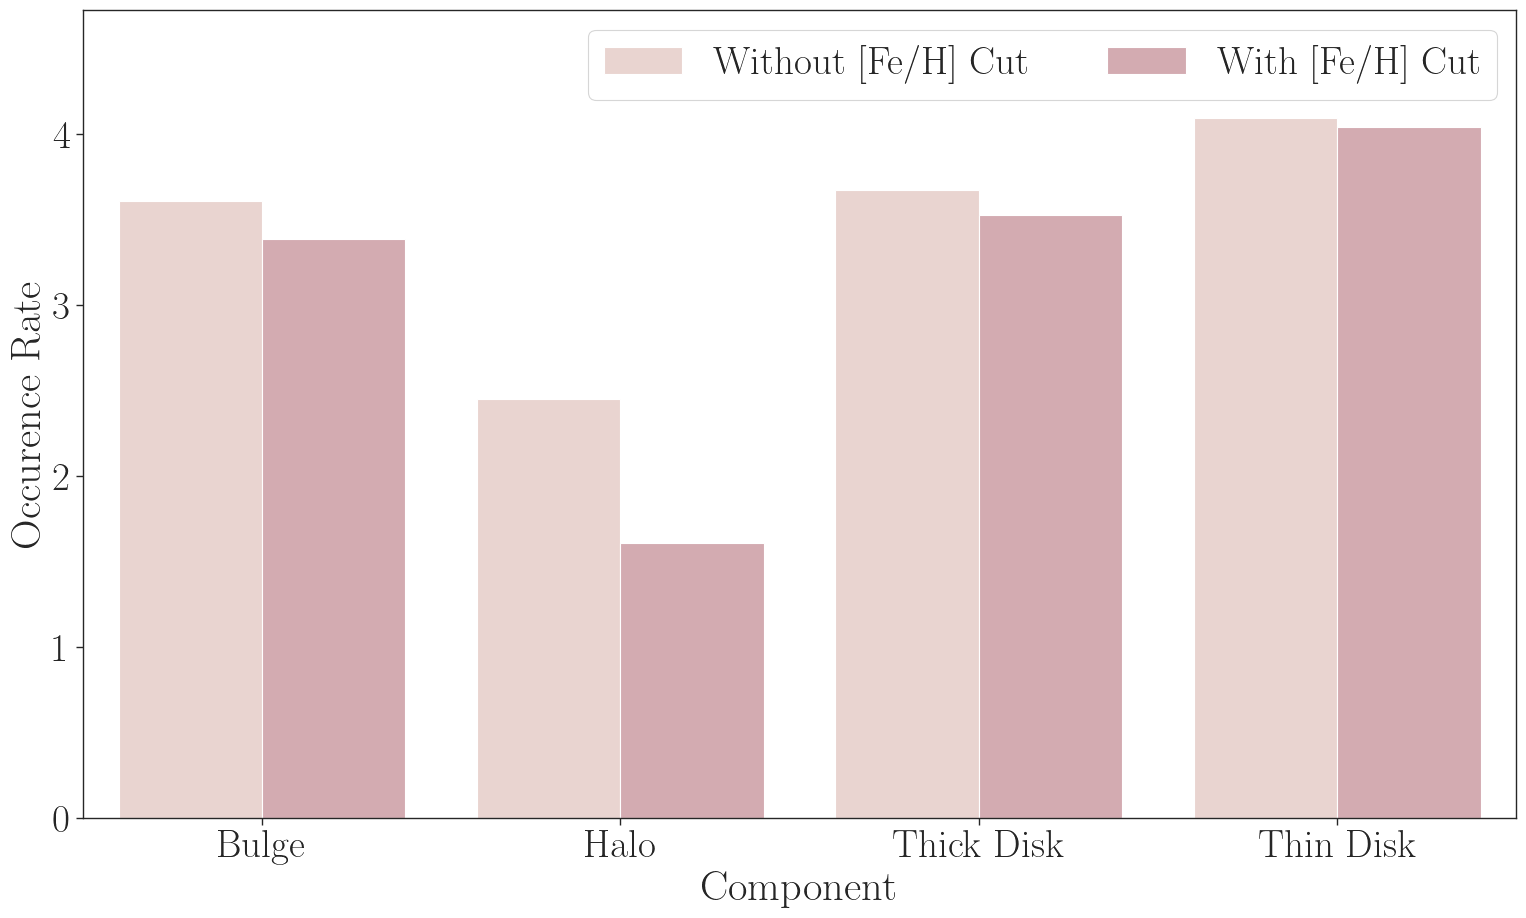

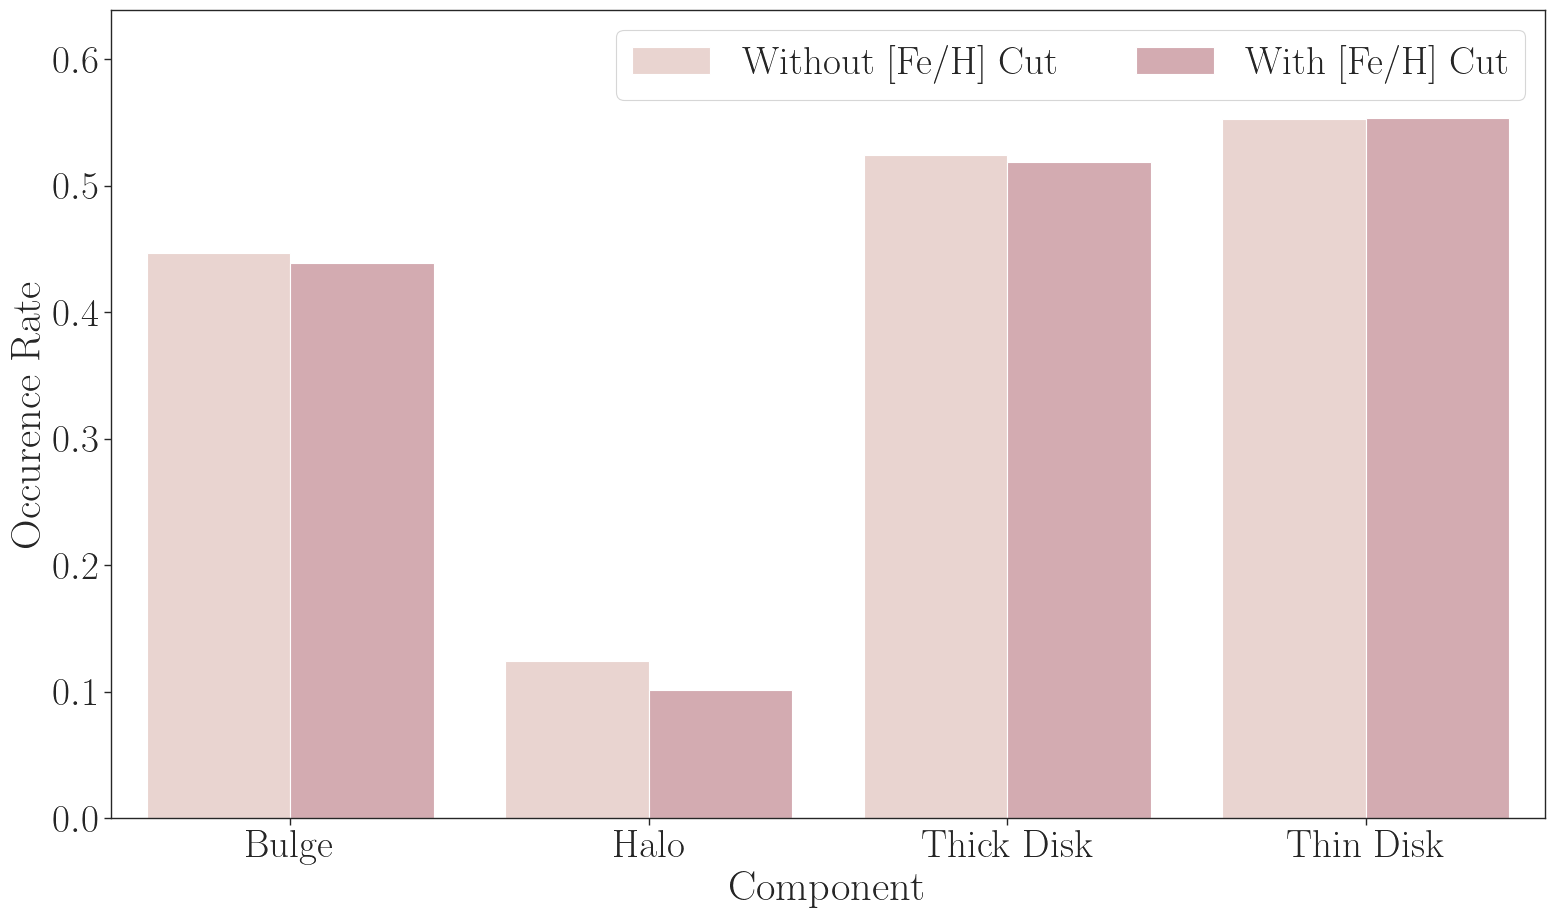

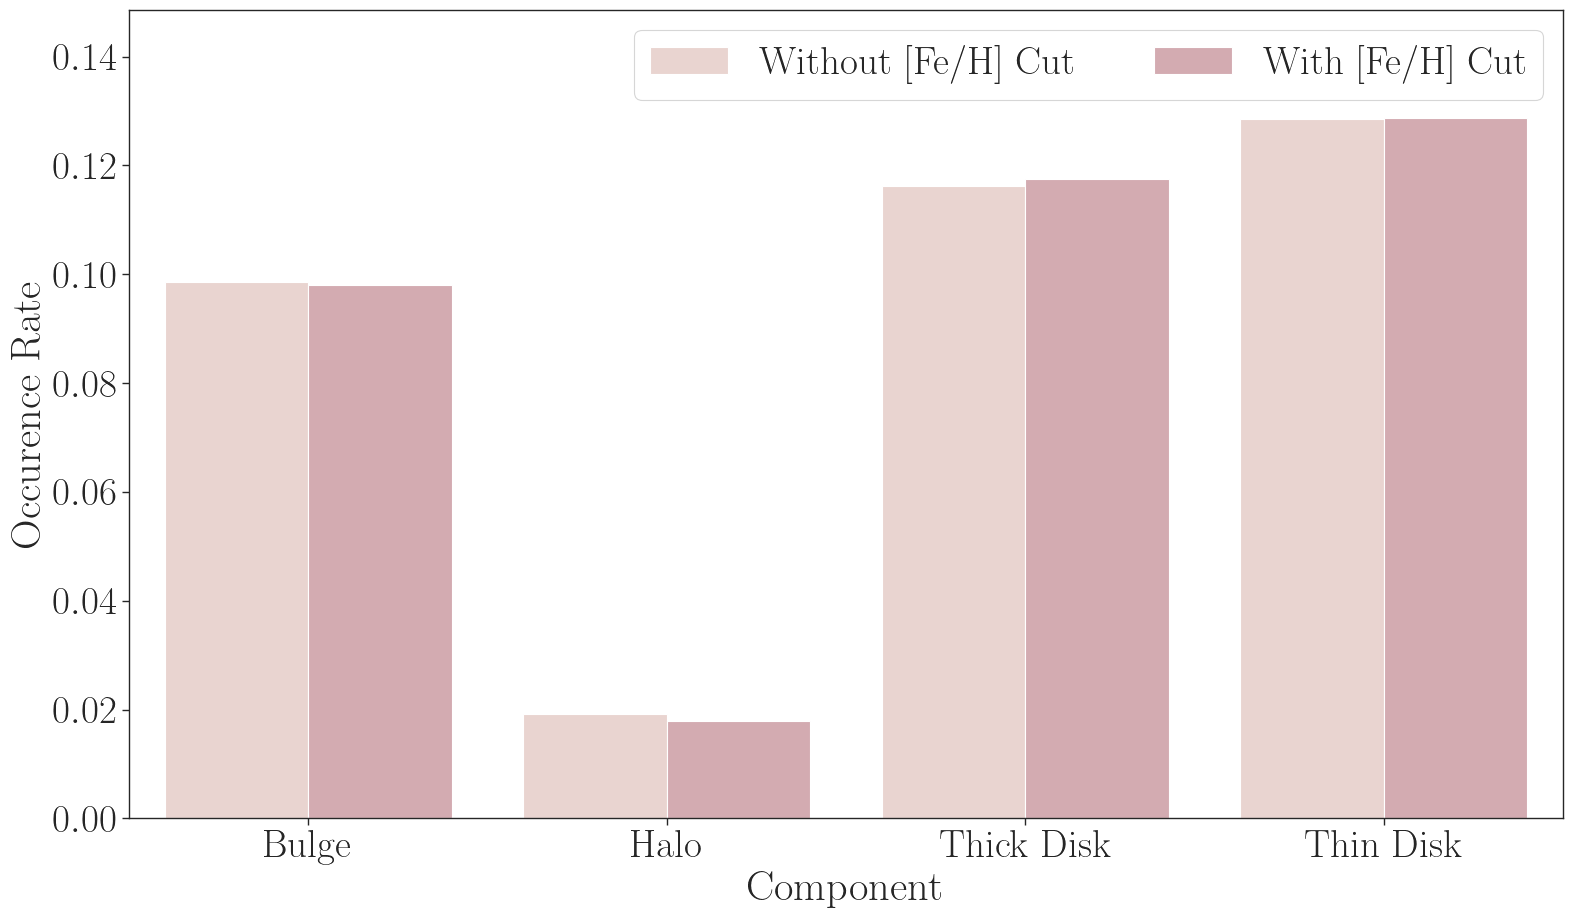

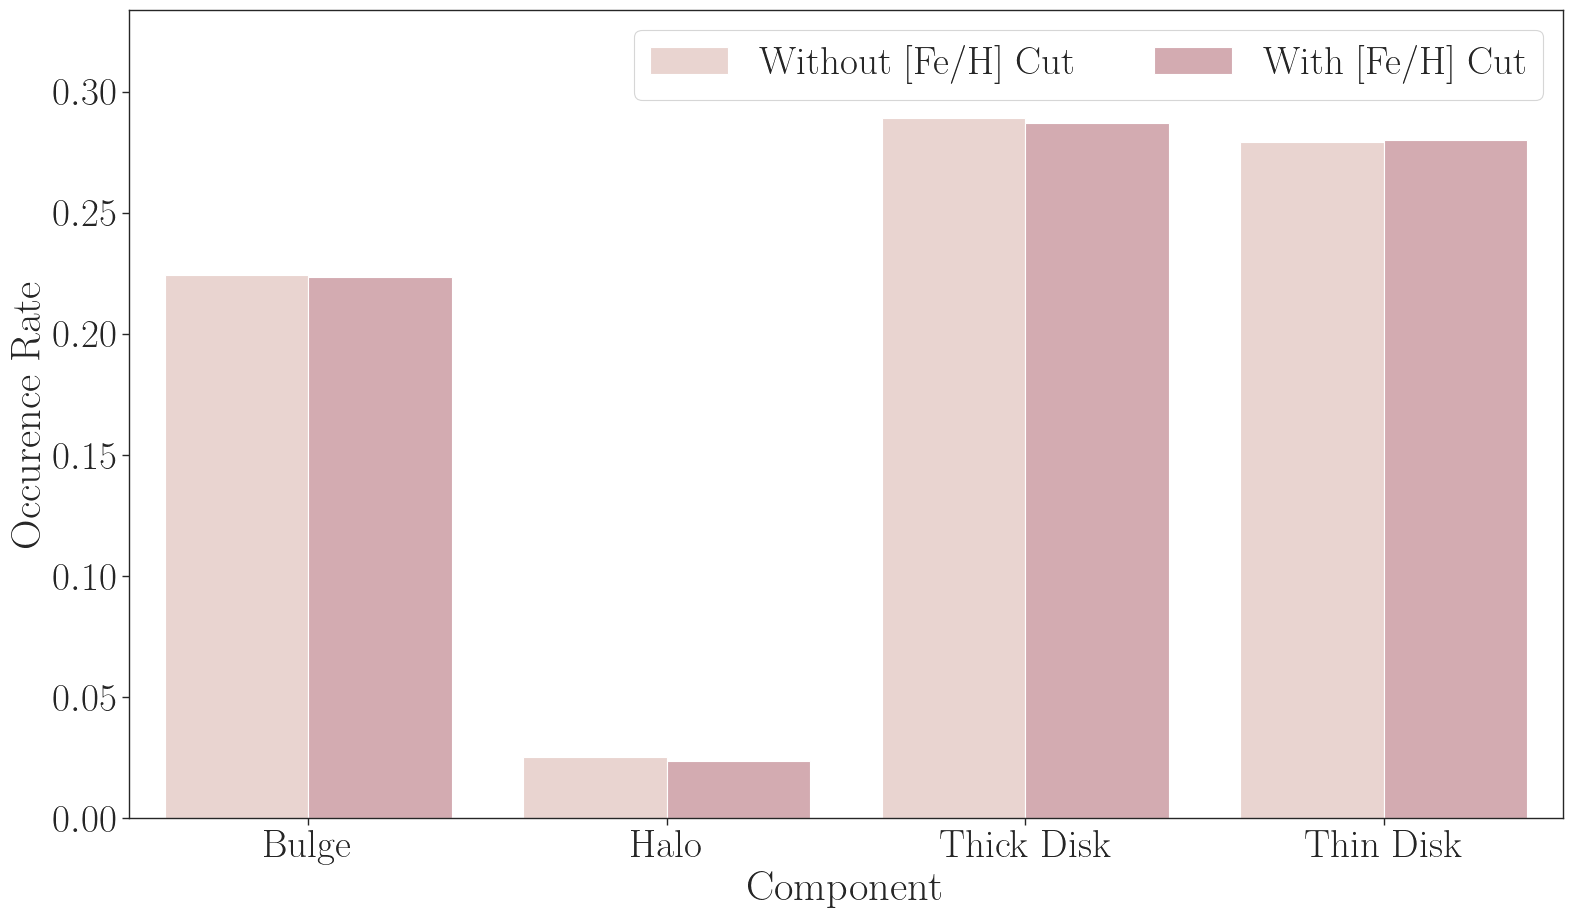

In [9]:
def barplot(occurence_rate_long_format, planet_type):
    plt.figure()
    with sns.axes_style("ticks"):
        occurence_rate_barplot = sns.barplot(
            data=occurence_rate_long_format,
            x="Component",
            y="Occurence Rate",
            hue="Metallicity Model",
            log=False,
            palette=get_palette(),
        )
    # adjust legend
    occurence_rate_barplot = adjust_legend(occurence_rate_barplot, pad=1.1)

    FigureProcessor(occurence_rate_barplot.figure).save(
        f"metallicity_effect_{planet_type}.pdf",
        sub_directory=figure_subdirectory,
        save=save,
    )


for planet_type in planet_categories:
    occurrence_rate_planet_type = occurrence_rate_combined[
        occurrence_rate_combined["Planet Type"] == planet_type
    ]
    plot = barplot(occurrence_rate_planet_type, planet_type=planet_type)